In [2]:
from pybaseball import statcast
from pybaseball import playerid_lookup
from pybaseball import statcast_pitcher

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

In [3]:
pitcher_lookup = playerid_lookup('flaherty', 'jack')
pitcher_lookup

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,flaherty,jack,656427,flahj002,flaheja01,17479,2017.0,2024.0


In [4]:
print(pitcher_lookup['key_mlbam'].iloc[0])

656427


In [5]:
pitcher_2024  = statcast_pitcher('2024-03-01', '2024-12-01', pitcher_lookup['key_mlbam'].iloc[0])
pitcher_2024.groupby("pitch_type").release_speed.agg("mean")

Gathering Player Data


pitch_type
CH    85.727586
FF    93.372607
KC    77.555939
SI    90.209589
SL    84.945464
Name: release_speed, dtype: float64

In [6]:
pitcher_2024.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description',
       ...
       'n_thruorder_pitcher', 'n_priorpa_thisgame_player_at_bat',
       'pitcher_days_since_prev_game', 'batter_days_since_prev_game',
       'pitcher_days_until_next_game', 'batter_days_until_next_game',
       'api_break_z_with_gravity', 'api_break_x_arm', 'api_break_x_batter_in',
       'arm_angle'],
      dtype='object', length=113)

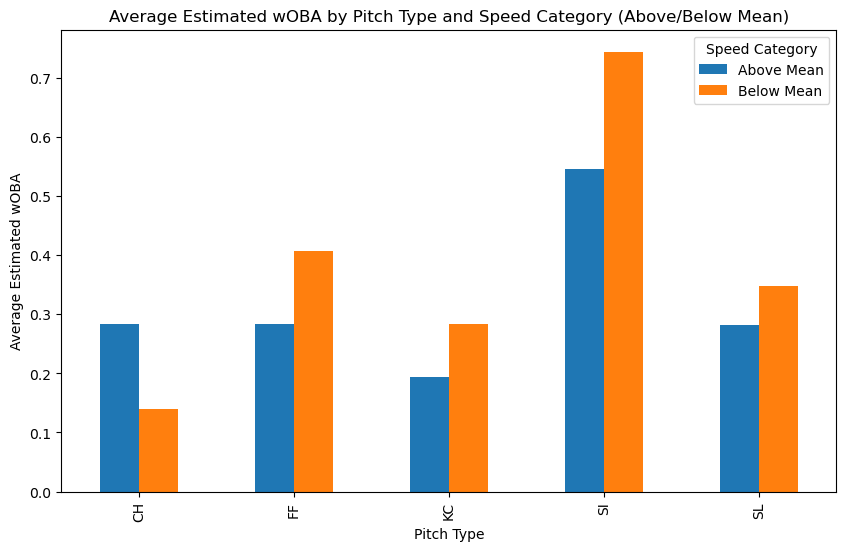

In [7]:
# Step 1: Calculate mean release speed for each pitch type
pitch_type_means = pitcher_2024.groupby("pitch_type")["release_speed"].transform("mean")

# Step 2: Create a new column indicating if the speed is above or below the pitch type mean
pitcher_2024["speed_category"] = pitcher_2024["release_speed"] > pitch_type_means
pitcher_2024["speed_category"] = pitcher_2024["speed_category"].replace({True: "Above Mean", False: "Below Mean"})

# Step 3: Group by both pitch_type and speed_category, then calculate mean estimated wOBA
woba_by_pitch_speed = pitcher_2024.groupby(["pitch_type", "speed_category"])["estimated_woba_using_speedangle"].mean().unstack()

# Step 4: Plot the results
woba_by_pitch_speed.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Pitch Type")
plt.ylabel("Average Estimated wOBA")
plt.title("Average Estimated wOBA by Pitch Type and Speed Category (Above/Below Mean)")
plt.legend(title="Speed Category")
plt.show()


In [11]:
fastball_data = pitcher_2024[pitcher_2024['pitch_type'] == 'FF'].copy()
list(fastball_data.columns)

['pitch_type',
 'game_date',
 'release_speed',
 'release_pos_x',
 'release_pos_z',
 'player_name',
 'batter',
 'pitcher',
 'events',
 'description',
 'spin_dir',
 'spin_rate_deprecated',
 'break_angle_deprecated',
 'break_length_deprecated',
 'zone',
 'des',
 'game_type',
 'stand',
 'p_throws',
 'home_team',
 'away_team',
 'type',
 'hit_location',
 'bb_type',
 'balls',
 'strikes',
 'game_year',
 'pfx_x',
 'pfx_z',
 'plate_x',
 'plate_z',
 'on_3b',
 'on_2b',
 'on_1b',
 'outs_when_up',
 'inning',
 'inning_topbot',
 'hc_x',
 'hc_y',
 'tfs_deprecated',
 'tfs_zulu_deprecated',
 'umpire',
 'sv_id',
 'vx0',
 'vy0',
 'vz0',
 'ax',
 'ay',
 'az',
 'sz_top',
 'sz_bot',
 'hit_distance_sc',
 'launch_speed',
 'launch_angle',
 'effective_speed',
 'release_spin_rate',
 'release_extension',
 'game_pk',
 'fielder_2',
 'fielder_3',
 'fielder_4',
 'fielder_5',
 'fielder_6',
 'fielder_7',
 'fielder_8',
 'fielder_9',
 'release_pos_y',
 'estimated_ba_using_speedangle',
 'estimated_woba_using_speedangle',
 'w

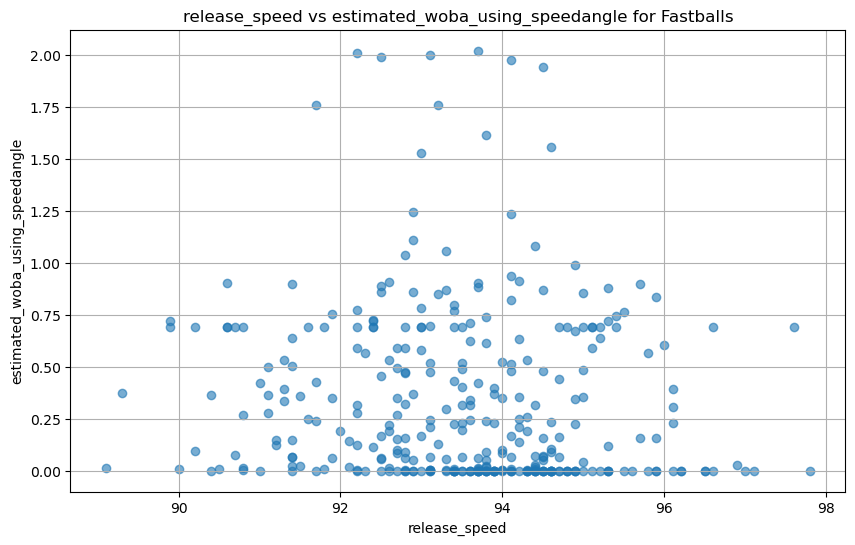

In [13]:
# Define the x and y columns you'd like to plot
x_column = 'release_speed'  # Choose a column name from fastball_data.columns for x-axis
y_column = 'estimated_woba_using_speedangle'  # Choose a column name from fastball_data.columns for y-axis

# Plot the data
plt.figure(figsize=(10, 6))
plt.scatter(fastball_data[x_column], fastball_data[y_column], alpha=0.6)
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column} for Fastballs')
plt.grid(True)
plt.show()

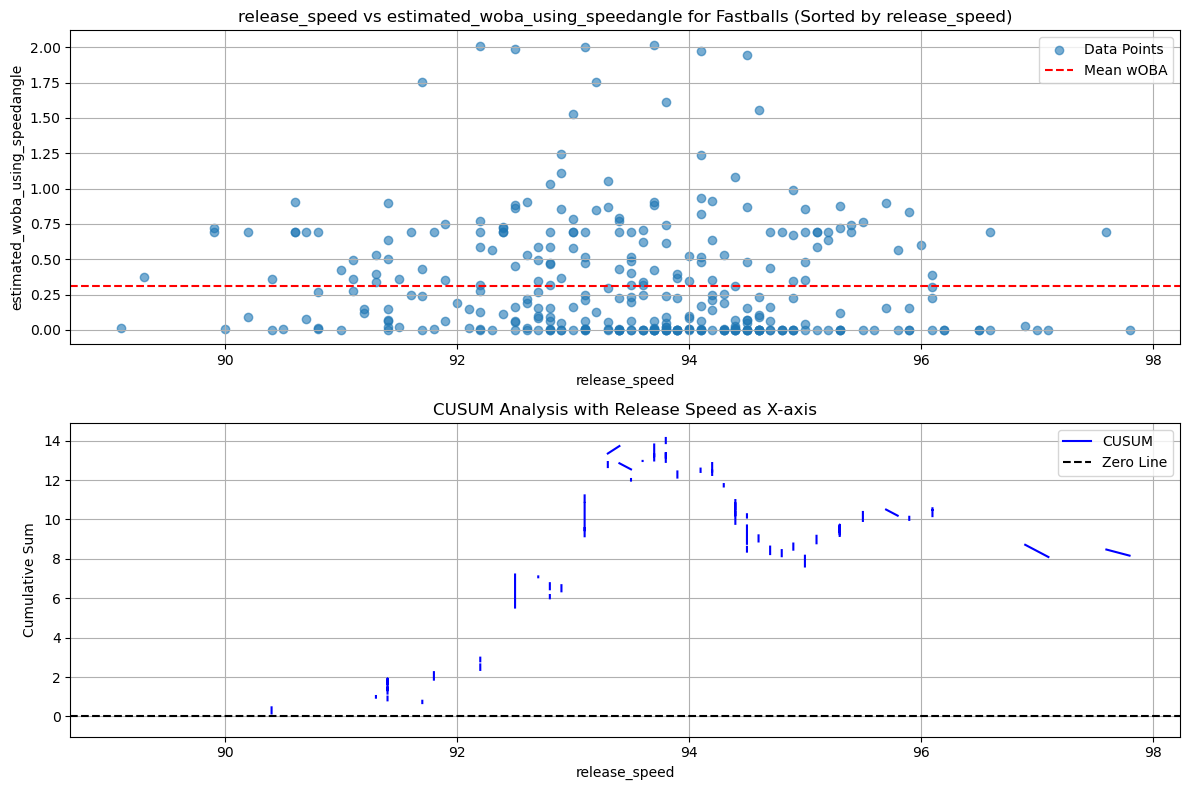

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define x and y columns
x_column = 'release_speed'
y_column = 'estimated_woba_using_speedangle'

# Sort fastball_data by release_speed
fastball_data_sorted = fastball_data.sort_values(by=x_column).reset_index(drop=True)

# Extract the sorted columns
x_data = fastball_data_sorted[x_column]
y_data = fastball_data_sorted[y_column]

# Compute the target value (mean or baseline for wOBA)
target = 0.310
# y_data.mean()  # You can adjust this target based on your goal

# Compute deviations from the target
deviations = y_data - target

# Calculate the CUSUM
cusum = np.cumsum(deviations)

# Plot the scatter plot
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.scatter(x_data, y_data, alpha=0.6, label='Data Points')
plt.axhline(target, color='red', linestyle='--', label='Mean wOBA')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.title(f'{x_column} vs {y_column} for Fastballs (Sorted by {x_column})')
plt.legend()
plt.grid(True)

# Plot the CUSUM with release_speed as the x-axis
plt.subplot(2, 1, 2)
plt.plot(x_data, cusum, label='CUSUM', color='blue')
plt.axhline(0, color='black', linestyle='--', label='Zero Line')
plt.xlabel(x_column)
plt.ylabel('Cumulative Sum')
plt.title('CUSUM Analysis with Release Speed as X-axis')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()